In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Chapter 3 - Inferences with binomials
## 3.1 Inferring a rate


Inferring the rate $\theta$ of a binary process  
$$ \theta \sim \text{Beta}(1, 1)  $$
$$ k \sim \text{Binomial} ( \theta, n)  $$

In the example, we set k = 5 and n = 10

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_logodds__]
100%|██████████| 1000/1000 [00:01<00:00, 695.13it/s]


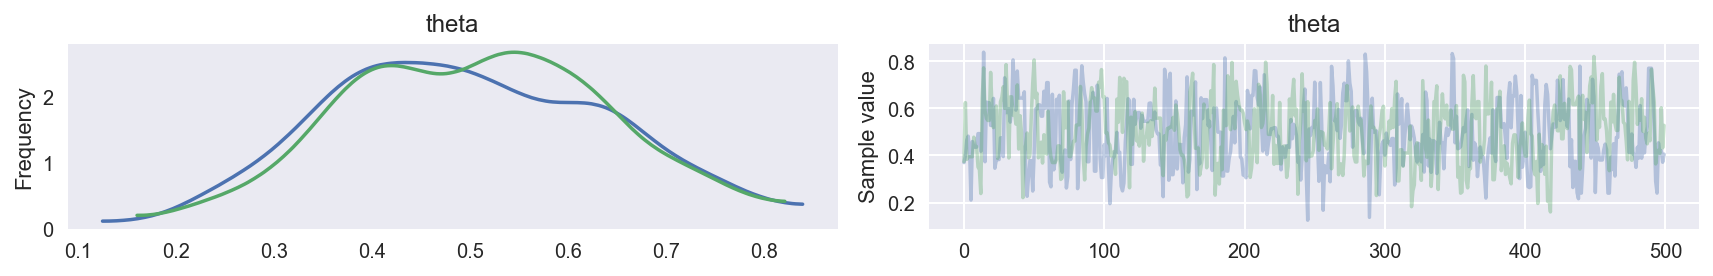

In [2]:
# Data
k = np.array([5])
n = np.array([10])

with pm.Model() as model1:
    # prior
    theta = pm.Beta('theta', alpha=1, beta=1)
    # observed
    x = pm.Binomial('x', n=n, p=theta, observed=k)
    # inference
    trace1 = pm.sample()

pm.traceplot(trace1, varnames=['theta']);

And generate a picture that is identical to 3.2 one on page 39 of Wagenmakers, 2013:

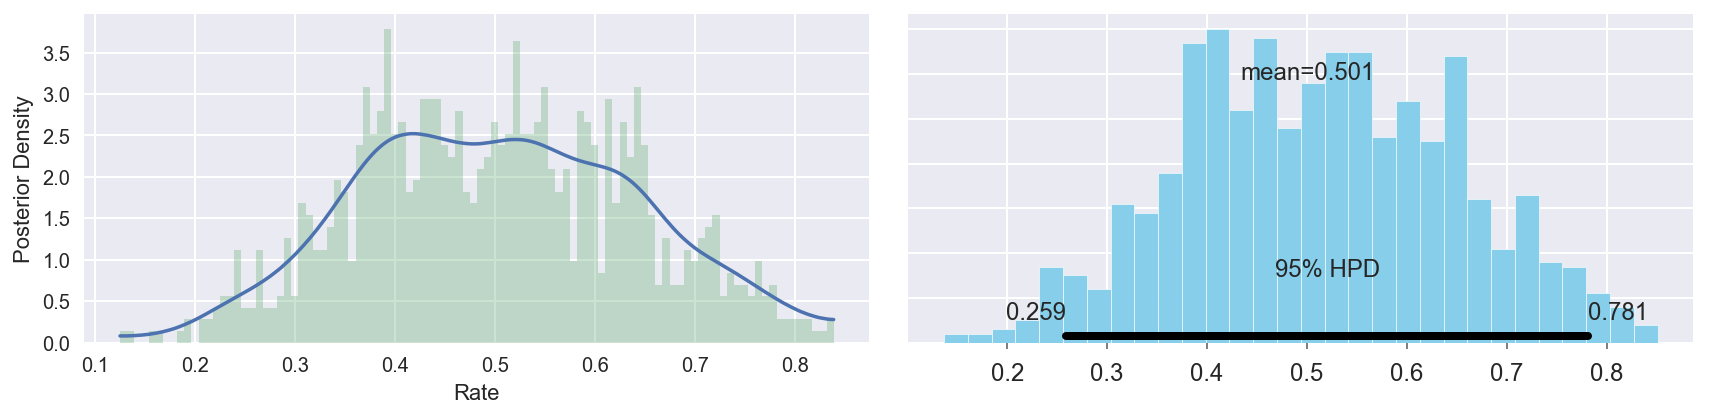

In [3]:
_, axes = plt.subplots(1, 2, figsize=(12, 3))
pm.kdeplot(trace1['theta'], ax=axes[0])
axes[0].hist(trace1['theta'], bins=100, normed=1, alpha=.3)
axes[0].set_xlabel('Rate')
axes[0].set_ylabel('Posterior Density')

pm.plot_posterior(trace1['theta'], ax=axes[1], color='#87ceeb')
plt.tight_layout();

In [4]:
pm.summary(trace1, varnames=['theta']).round(3)# gives the same credible interval as in the book.

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.501,0.137,0.006,0.259,0.781,375.0,1.0


## 3.2 Difference between two rates

Inferring the rate $\theta$ of two binary process  
$$ \theta \sim \text{Beta}(1, 1)  $$
$$ k \sim \text{Binomial} ( \theta, n)  $$

In the example, we set k1 = 5, n1 = 10 and k2 = 7, n2 = 10 

The model involve a deterministic part in pymc3.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta2_logodds__, theta1_logodds__]
100%|██████████| 1000/1000 [00:02<00:00, 346.63it/s]


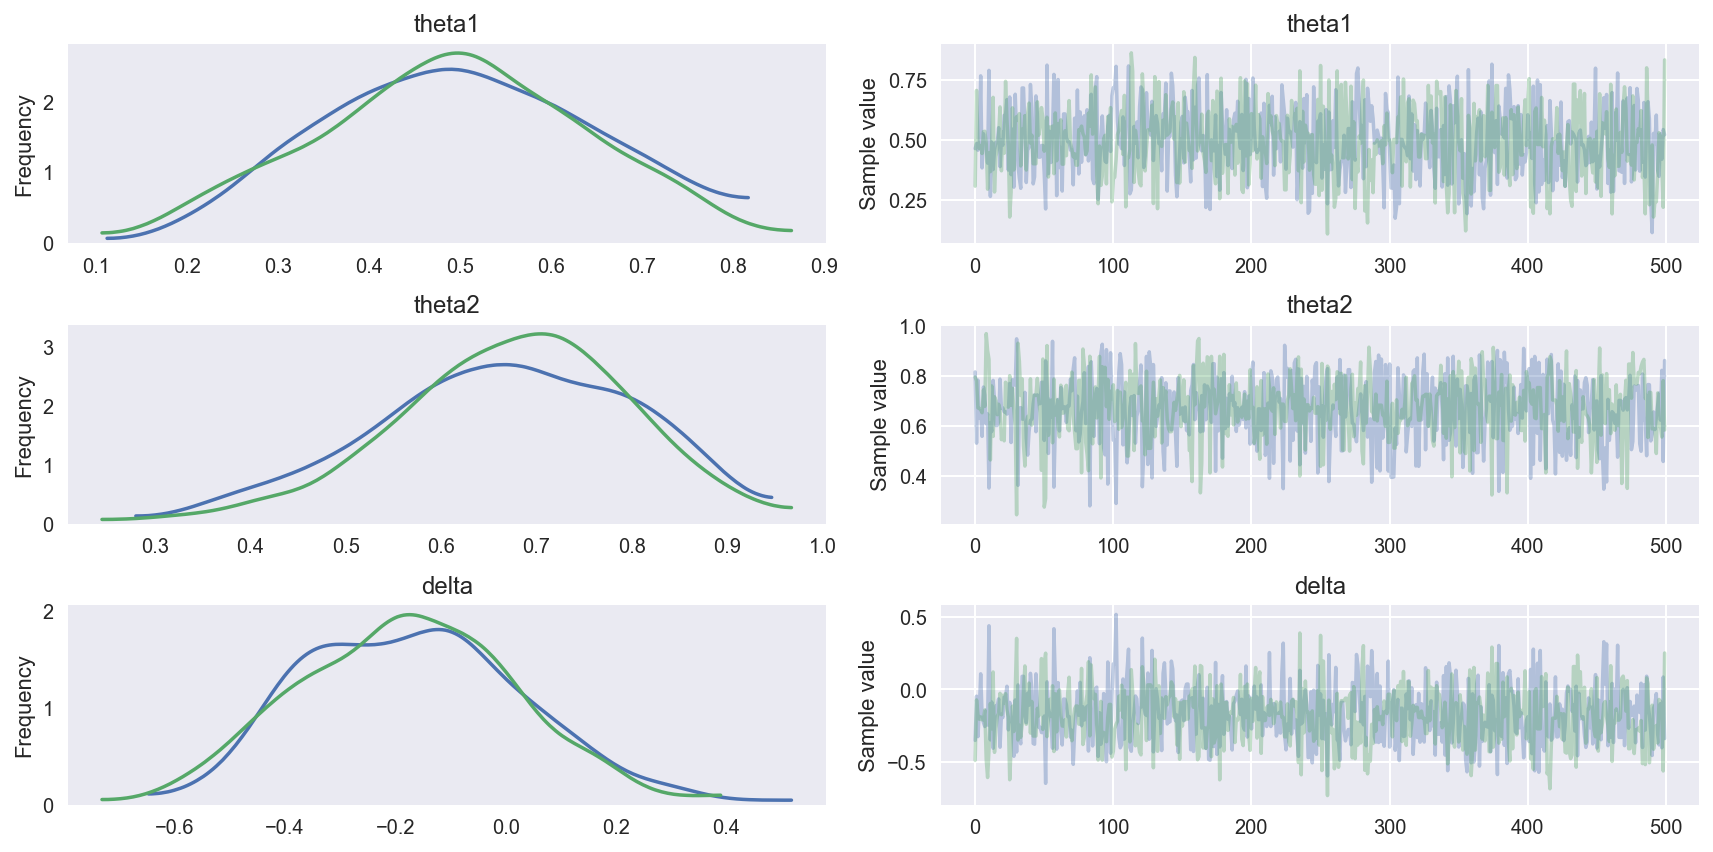

In [5]:
# data
k1, k2 = 5, 7
n1 = n2 = 10

with pm.Model() as model2:
    # prior
    theta1 = pm.Beta('theta1', alpha=1, beta=1)
    theta2 = pm.Beta('theta2', alpha=1, beta=1)
    # observed
    x1 = pm.Binomial('x1', n=n1, p=theta1, observed=k1)
    x2 = pm.Binomial('x2', n=n2, p=theta2, observed=k2)
    # differences as deterministic
    delta = pm.Deterministic('delta', theta1-theta2)
    # inference
    trace2 = pm.sample()

pm.traceplot(trace2);

In [6]:
pm.summary(trace2).round(3)# gives the credible interval

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta1,0.494,0.145,0.004,0.212,0.759,1000.0,1.000
theta2,0.668,0.128,0.004,0.411,0.900,1000.0,1.001
delta,-0.173,0.197,0.005,-0.547,0.197,1000.0,1.001


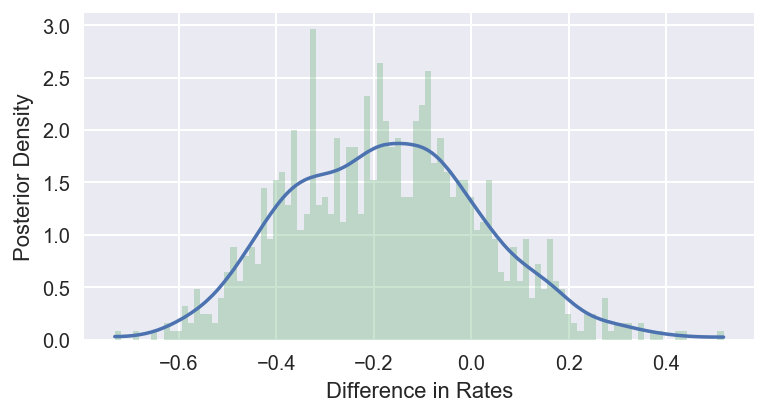

In [7]:
_, axes = plt.subplots(1, 1, figsize=(6, 3))
pm.kdeplot(trace2['delta'], ax=axes)
axes.hist(trace2['delta'], bins=100, normed=1, alpha=.3)
axes.set_xlabel('Difference in Rates')
axes.set_ylabel('Posterior Density');

## 3.3 Inferring a common rate

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_logodds__]
100%|██████████| 1500/1500.0 [00:01<00:00, 1194.15it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.589,0.101,0.003,0.386,0.771,820.0,1.001


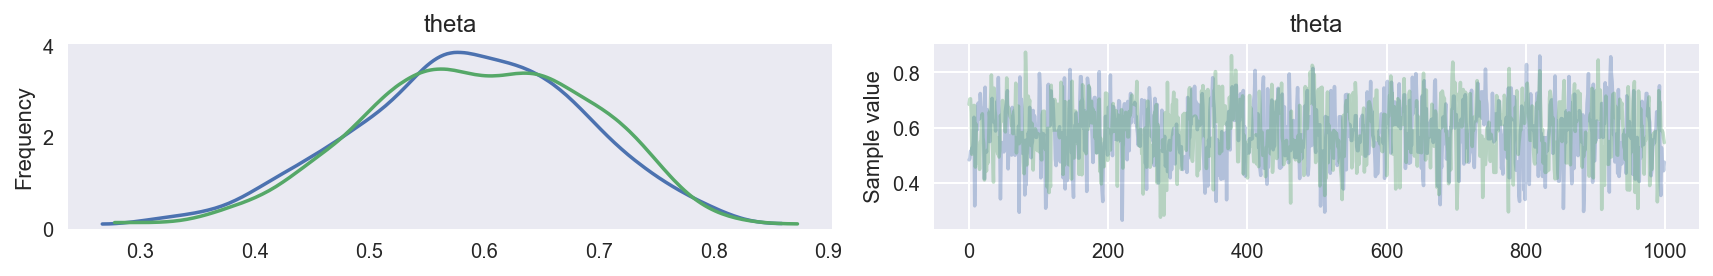

In [8]:
# Multiple trials
k = np.array([5, 7])
n = np.array([10, 10])

with pm.Model() as model3:
    # prior
    theta = pm.Beta('theta', alpha=1, beta=1)
    # observed
    x = pm.Binomial('x', n=n, p=theta, observed=k)
    # inference
    trace3 = pm.sample(1e3)

pm.traceplot(trace3, varnames=['theta']);
pm.summary(trace3).round(3)

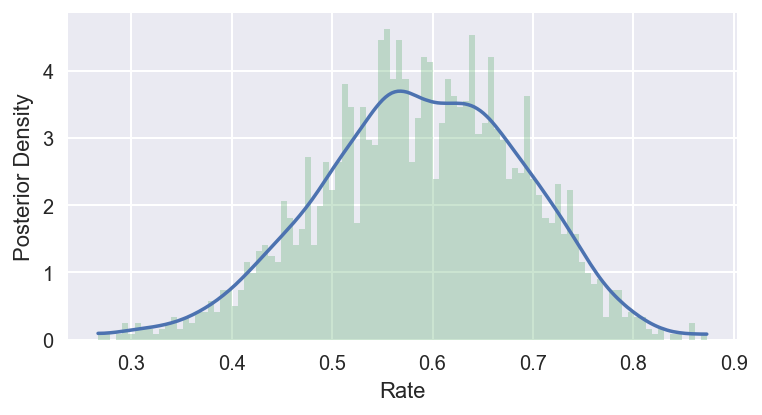

In [9]:
_, axes = plt.subplots(1, 1, figsize=(6, 3))
pm.kdeplot(trace3['theta'], ax=axes)
axes.hist(trace3['theta'], bins=100, normed=1, alpha=.3)

axes.set_xlabel('Rate')
axes.set_ylabel('Posterior Density');

## 3.4 Prior and posterior prediction

In [10]:
k = 1
n = 15
# Uncomment for Trompetter Data
# k = 24
# n = 121

# prior only model - no observation
with pm.Model() as model_prior:
    theta = pm.Beta('theta', alpha=1, beta=1)
    x = pm.Binomial('x', n=n, p=theta)
    trace_prior = pm.sample(1000, compute_convergence_checks=False)
    
# with observation
with pm.Model() as model_obs:
    theta = pm.Beta('theta', alpha=1, beta=1)
    x = pm.Binomial('x', n=n, p=theta, observed=k)
    trace_obs = pm.sample(1000)
    
# prediction (sample from trace)
ppc = pm.sample_ppc(trace_obs, samples=500, model=model_obs)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [theta_logodds__]
>Metropolis: [x]
100%|██████████| 1500/1500 [00:01<00:00, 808.01it/s] 
The acceptance probability does not match the target. It is 0.7122825908387618, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_logodds__]
100%|██████████| 500/500 [00:00<00:00, 4094.60it/s]


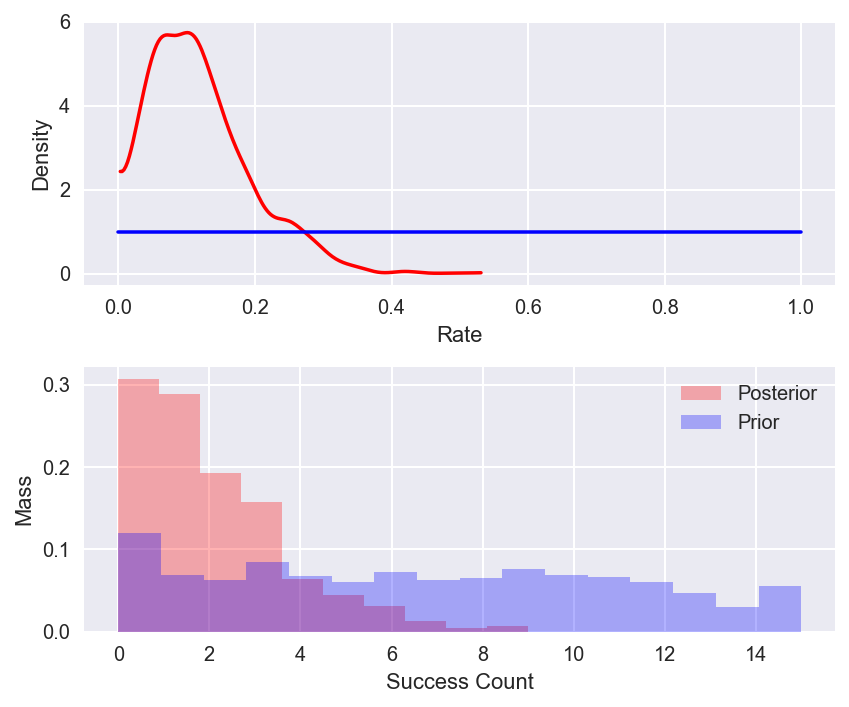

In [11]:
from scipy.stats import beta

prior_x = trace_prior['x']
pred_theta = trace_obs['theta']

_, axes = plt.subplots(2, 1, figsize=(6, 5))

pm.kdeplot(pred_theta, ax=axes[0], color='r', label='Posterior')
x = np.linspace(0, 1, 100)
axes[0].plot(x, beta.pdf(x, 1, 1), color='b', label='Prior')
axes[0].set_xlabel('Rate')
axes[0].set_ylabel('Density')

predictx = ppc['x']
axes[1].hist(predictx, normed=1, bins=len(np.unique(predictx)), 
         alpha=.3, color='r', label='Posterior')
axes[1].hist(prior_x, normed=1, bins=n+1, 
         alpha=.3, color='b', label='Prior')
axes[1].set_xlabel('Success Count')
axes[1].set_ylabel('Mass')

plt.legend()
plt.tight_layout();

## 3.5 Posterior Predictive

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_logodds__]
100%|██████████| 500/500 [00:00<00:00, 1679.16it/s]


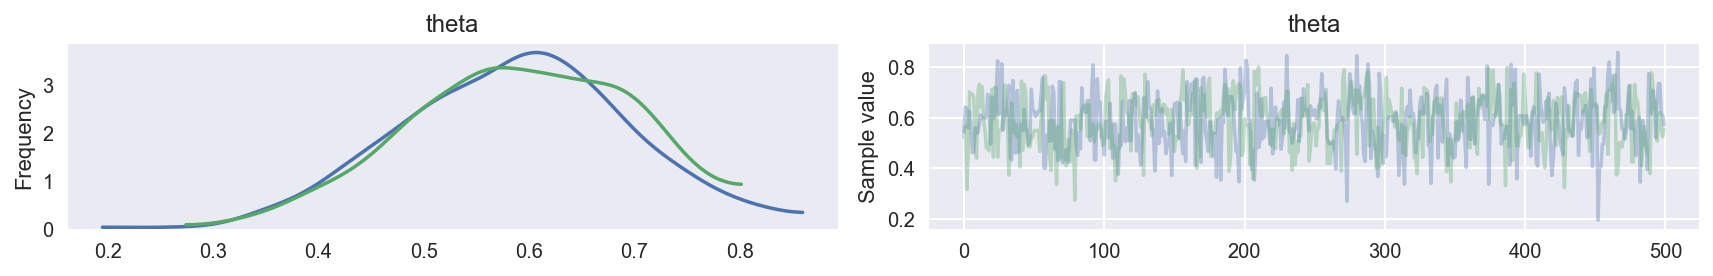

In [12]:
# Inferring a Common Rate, With Posterior Predictive
k1 = 2
n1 = 13
k2 = 10
n2 = 10

with pm.Model() as model5:
    # prior
    theta = pm.Beta('theta', alpha=1, beta=1)
    # observed
    x1 = pm.Binomial('x1', n=n2, p=theta, observed=k1)
    x2 = pm.Binomial('x2', n=n2, p=theta, observed=k2)
    # inference
    trace5 = pm.sample()

pm.traceplot(trace5, varnames=['theta']);
# prediction (sample from trace)
ppc5 = pm.sample_ppc(trace5, samples=500, model=model5)

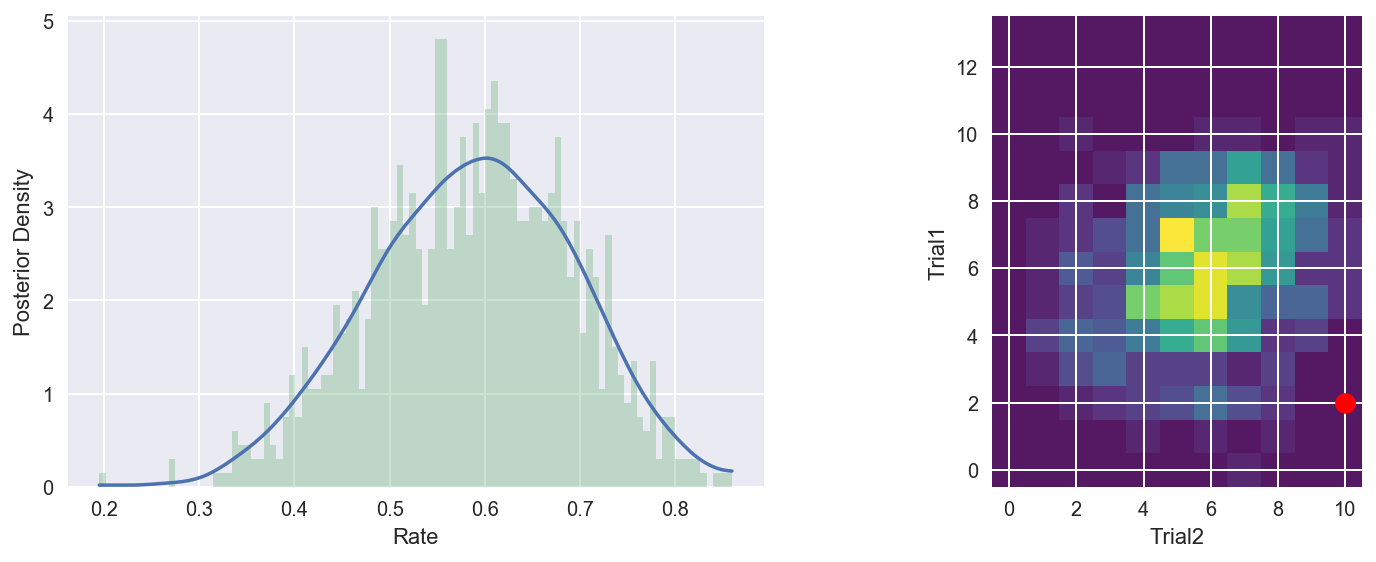

In [14]:
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(1,2, width_ratios=[2, 3]) 
ax0 = plt.subplot(gs[0])

pm.kdeplot(trace5['theta'], ax=ax0)
ax0.hist(trace5['theta'], bins=100, normed=1, alpha=.3)
plt.xlabel('Rate')
plt.ylabel('Posterior Density')

ax1 = plt.subplot(gs[1])
predx1 = ppc5['x1']
predx2 = ppc5['x2']

from scipy import sparse
A = sparse.csc_matrix((np.ones(len(predx1)), (predx1, predx2)), 
                      shape=(n1+1, n2+1)).todense()
ax1.imshow(A, alpha=.9, origin='lower', cmap='viridis')
ax1.scatter(k2, k1, s=100, c=[1,0,0])
plt.xlabel('Trial2')
plt.ylabel('Trial1')
plt.tight_layout();

## 3.6 Joint distributions

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [theta_logodds__]
>Metropolis: [TotalN]
100%|██████████| 10500/10500.0 [00:16<00:00, 636.66it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


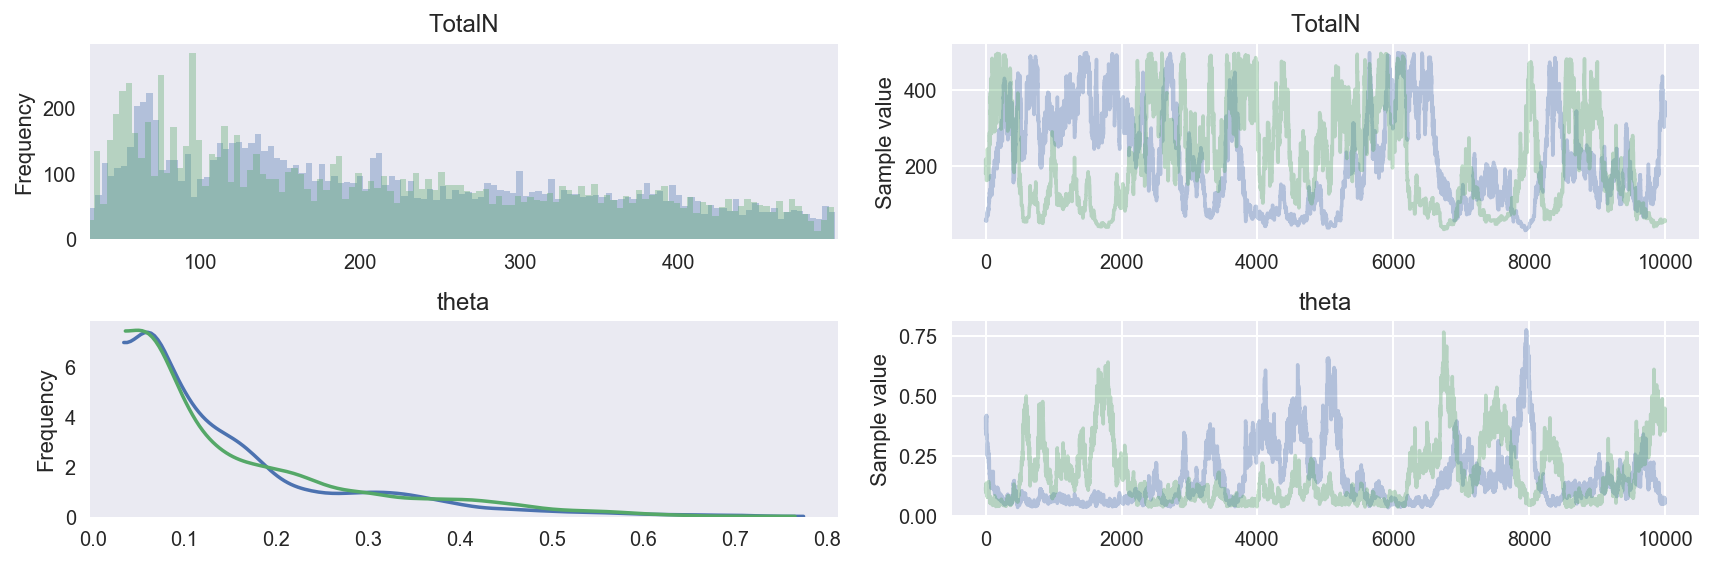

In [15]:
# the Survey example in the book
k = np.array([16, 18, 22, 25, 27])
nmax = 500
m = len(k)
    
with pm.Model() as model6:
    # prior
    theta = pm.Beta('theta', alpha=1,beta=1)
    TotalN = pm.DiscreteUniform('TotalN', lower=1, upper=nmax)
    # observed
    x = pm.Binomial('x', n=TotalN, p=theta, observed=k)
    # inference
    trace6 = pm.sample(1e4, cores=2)

pm.traceplot(trace6);

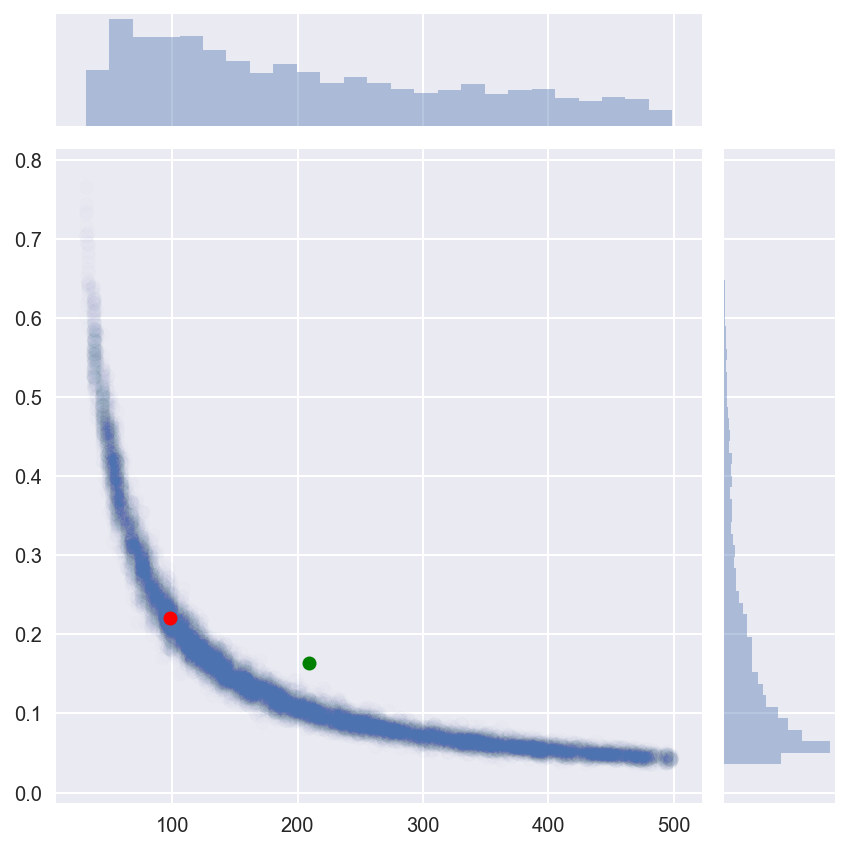

In [29]:
burnin = 9000
thetapost = trace6['theta'][burnin:]
npost = trace6['TotalN'][burnin:]

g = sns.jointplot(npost, thetapost, kind='scatter', stat_func=None, alpha=.01);

from scipy.special import gammaln
cc = -float('Inf')
ind = 0

for i in range(0, len(npost)):
    logL = 0
    for j in k:   
        logL = logL+gammaln(npost[i]+1)-gammaln(j+1)-gammaln(npost[i] - j +1)
        logL = logL+j*np.log(thetapost[i])+(npost[i]-j)*np.log(1-thetapost[i])
    
    if logL > cc: 
        ind = i
        cc = logL

g.ax_joint.plot(np.mean(npost), np.mean(thetapost), 'o', color='g')
g.ax_joint.plot(npost[ind], thetapost[ind], 'o', color='r');

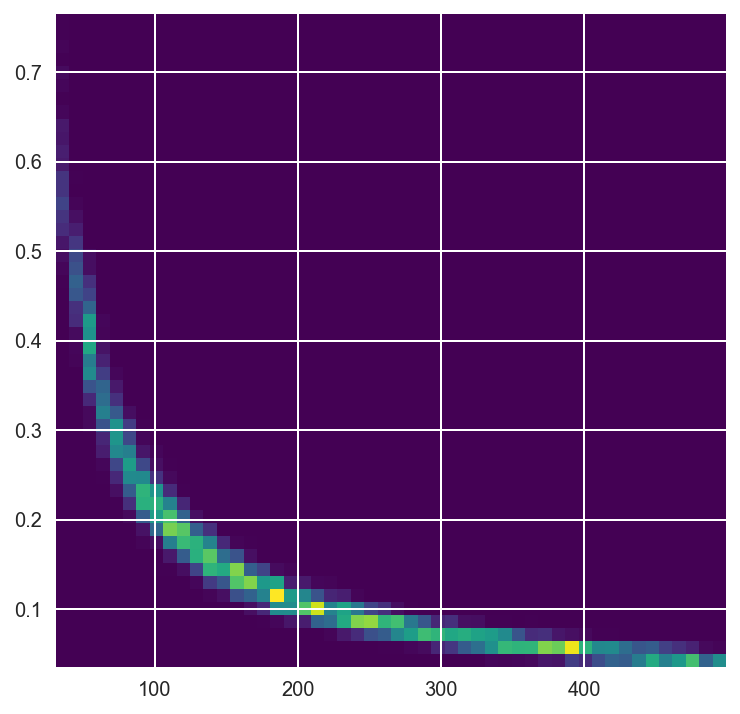

In [31]:
plt.figure(1, figsize=(6, 6))
plt.hist2d(npost, thetapost, bins=50, cmap='viridis');

### Note from Junpeng Lao
It is obvious from the above posterior plot that the geometry of the posterior is quite nasty. We can see that in the trace as well: the mixing is quite poor, with strong autocorrelation. There is no divergence warning, but it could just be that PyMC3 is mixing Metropolis and NUTS together due to the discrete variable. 
In this particular case, it is not a big deal as we can visualize the posterior directly. However, when we are sampling larger model, it is definitely going to be a problem.
Actually, we don't necessary need to use DiscreteUniform for TotalN, as the computation of logp in Binomial doesn't require n to be int.

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [TotalN_interval__, theta_logodds__]
INFO:pymc3:NUTS: [TotalN_interval__, theta_logodds__]
100%|██████████| 2000/2000.0 [00:47<00:00, 42.17it/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Incre

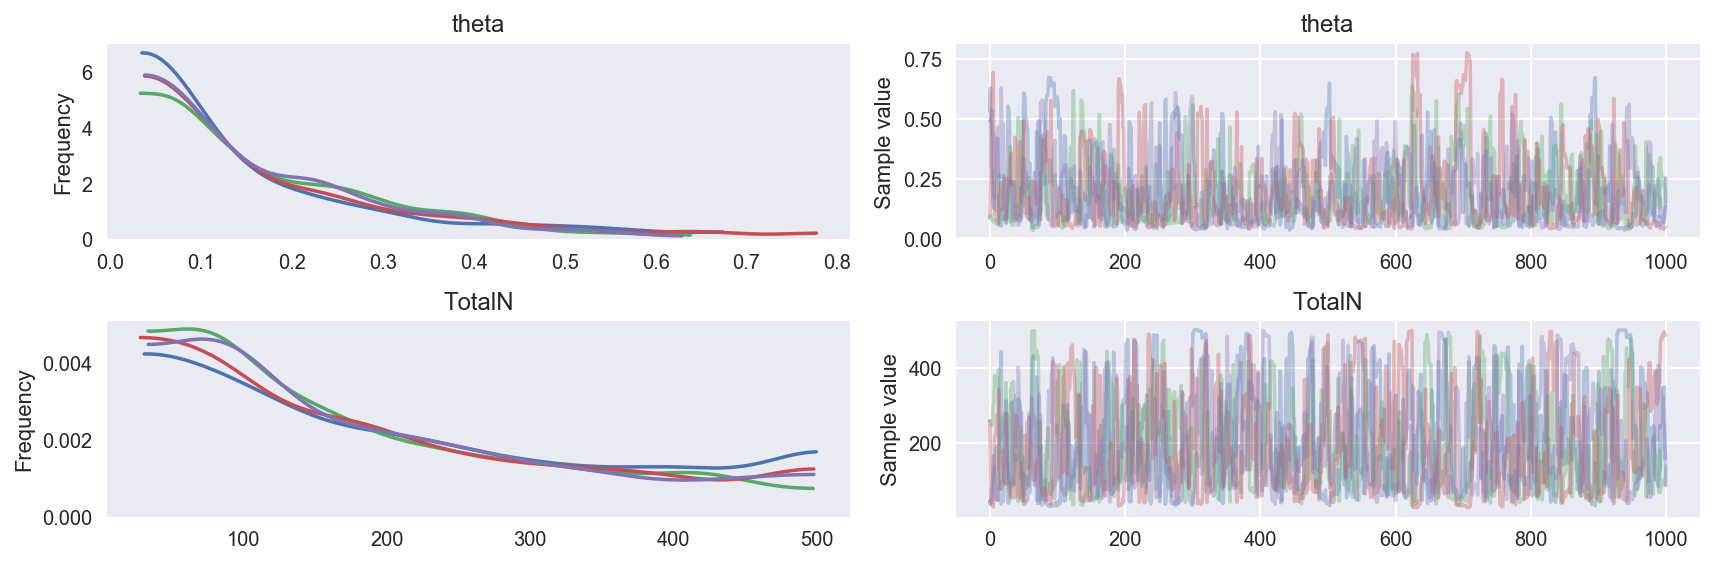

In [20]:
with pm.Model() as model6_:
    # prior
    theta = pm.Beta('theta', alpha=1,beta=1)
    TotalN = pm.Uniform('TotalN', lower=1, upper=nmax)
    # observed
    x = pm.Binomial('x', n=TotalN, p=theta, observed=k)
    # inference
    trace6_ = pm.sample(1e3, tune=1000, cores=4, nuts_kwargs = {'target_accept' : 0.99})

pm.traceplot(trace6_);

Not too surprisingly, we can see divergence warnings. We can further visualize them:

Number of Divergent 13
Percentage of Divergent 0.01300


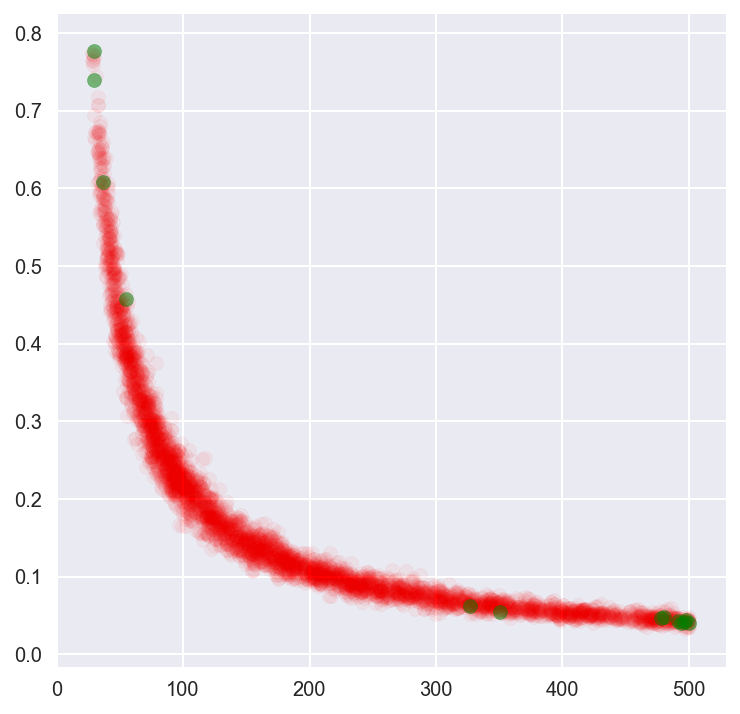

In [23]:
# display the total number and percentage of divergent
divergent = trace6_['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(trace6_)
print('Percentage of Divergent %.5f' % divperc)

# scatter plot between theta and N
# for the identifcation of the problematic neighborhoods in parameter space
theta_tr = trace6_['theta']
totaln_tr = trace6_['TotalN']
plt.figure(figsize=(6, 6))
plt.scatter(totaln_tr[divergent == 0], theta_tr[divergent == 0], color='r', alpha=.05)
plt.scatter(totaln_tr[divergent == 1], theta_tr[divergent == 1], color='g', alpha=.5);

It confirms our intuition that in the high curvature area (tails), our sampler is going to have difficulties.